In [31]:
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Team
from basketball_reference_web_scraper.data import OutputType
import pandas as pd
import datetime as datetime
from datetime import datetime, timedelta
from dateutil.parser import parse
from pulp import *
import numpy as np
from sklearn import linear_model
import os.path
from os import path
import seaborn as sns

In [ ]:
for m in range(1, 3):
    if m == 2:
        for d in range(1, 29):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)
    else:
        for d in range(1, 32):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)

In [41]:
client.player_box_scores(day=31, month=7, year=2020)

InvalidDate: Date with year set to 2020, month set to 7, and day set to 31 is invalid

In [2]:
all_tables = []
for m in range(1, 3):
    if m == 2:
        for d in range(1, 29):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            table  = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

    else:
        for d in range(1, 32):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            table  = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

In [3]:
full_df = all_tables[0]
for i in range(1, len(all_tables)):
    current_table = all_tables[i]
    full_df = full_df.append(current_table)
full_df.to_csv("./OutputCSVs/all_games.csv")

In [4]:
df = pd.read_csv("./OutputCSVs/teams_stats.csv")
df["Team"] = df["Team"].str.upper()
all_games = pd.read_csv("./OutputCSVs/all_games.csv")
x = all_games[["team", "opponent"]].loc[0]["team"]
df[df["Team"] == x]["TOV%"]

team_def = []
team_pace = []
team_tov = []
opp_def = []
opp_pace = []
opp_tov = []
all_games_teams = all_games[["team", "opponent"]]

for i in range(len(all_games_teams)):
    game = all_games_teams.loc[i]
    team = game["team"]
    opponent = game["opponent"]
    team_def.append(df[df["Team"] == team]["DRtg"].iloc[0])
    team_pace.append(df[df["Team"] == team]["Pace"].iloc[0])
    team_tov.append(df[df["Team"] == team]["TOV%"].iloc[0])
    opp_def.append(df[df["Team"] == opponent]["DRtg"].iloc[0])
    opp_pace.append(df[df["Team"] == opponent]["Pace"].iloc[0])
    opp_tov.append(df[df["Team"] == opponent]["TOV%"].iloc[0])
    
all_games["Team Defensive Rating"] = team_def
all_games["Team Pace"] = team_pace
all_games["Team Turnover %"] = team_tov
all_games["Opponent Defensive Rating"] = opp_def
all_games["Opponent Pace"] = opp_pace
all_games["Opponent Turnover %"] = opp_tov

all_games.to_csv("./OutputCSVs/all_games_new.csv")
df = pd.read_csv("./OutputCSVs/all_games_new.csv")
attempted_2s = df["attempted_field_goals"] - df["attempted_three_point_field_goals"]
made_2s = df["made_field_goals"] - df["made_three_point_field_goals"]
rebounds = df["offensive_rebounds"] + df["defensive_rebounds"]
at_home = df["location"] == "HOME"
df["attempted_two_point_field_goals"] = attempted_2s
df["made_two_point_field_goals"] = made_2s
df["total_rebounds"] = rebounds
df["at_home"] = at_home
df.to_csv("./OutputCSVs/all_games_updated.csv")
all_games_actual = pd.read_csv("./OutputCSVs/all_games_updated.csv")
all_games_actual =  all_games_actual.iloc[:, 3:].reset_index()

In [5]:
def get_stats(player, date, number_rows):
    converted_datetime = datetime.strptime(date, '%Y-%m-%d')
    player_rows = all_games_actual.loc[all_games_actual['name'] == player]
    #print(player_rows)
    selected_rows = []
    if (len(player_rows)) < number_rows:
        for i in range(len(player_rows)):
            selected_rows.append(player_rows.iloc[i])
        return pd.DataFrame(selected_rows)
    index = 0
    for i in range(len(player_rows)):
        curr_date = player_rows.iloc[i]['Date']
        if datetime.strptime(curr_date, '%Y-%m-%d') >= converted_datetime:
            index = i - 1
            break
    if index != 0:
        if index + 1 - number_rows < 0:
            for i in range(index + 1):
                selected_rows.append(player_rows.iloc[i])
        else:
            for i in range(index + 1 - number_rows, index + 1):
                selected_rows.append(player_rows.iloc[i])
#     elif converted_datetime >= players_rows[len(player_rows) - 1]:
    else:
        for i in range(len(player_rows) - number_rows, len(player_rows)):
            selected_rows.append(player_rows.iloc[i])
    return pd.DataFrame(selected_rows)

In [6]:
def get_points(row_data):
    three_pt_fgs = row_data['made_three_point_field_goals']
    two_pt_fgs = row_data['made_two_point_field_goals']
    made_fts = row_data['made_free_throws']
    total_rebounds = row_data['rebounds']
    assists = row_data['assists']
    blocks = row_data['blocks']
    steals = row_data['steals']
    turnovers = row_data['turnovers']
    FD_points = three_pt_fgs * 3 + two_pt_fgs * 2 + made_fts + total_rebounds * 1.2 + assists * 1.5 + blocks * 3 + steals * 3 - turnovers
    FD_dollars = FD_points * 200
    return (FD_points, FD_dollars)

In [7]:
def weight_function(statistic, weight):
    s = 0
    if type(statistic) == np.ndarray:
        for i in range(len(statistic)):
            s += statistic[len(statistic) - i - 1] * (weight ** i)
    else:
        for i in range(len(statistic)):
            s += statistic.iloc[len(statistic) - i - 1,] * (weight ** i)
    return s

In [8]:
def time_weighted_average(rows, statistic, weight):
    if rows.empty:
        return 0
    stat = rows[statistic]
    this_num = 1 / weight_function(np.ones(len(stat)), weight)
    return this_num * weight_function(stat, weight)
player_box_scores = pd.read_csv('./OutputCSVs/all_games_updated.csv')

input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %"]

In [35]:
def statline_predictor(player_box_scores, input_statistics, sample_size = 5, weight = .8):
    player_box_scores = player_box_scores[~player_box_scores.index.duplicated()]
    player_box_scores.reindex(range(len(player_box_scores)), axis = "index")
    predicted_statlines = pd.DataFrame(index = player_box_scores.index, columns = input_statistics).fillna(0).T
    index_len = len(player_box_scores.index)
    for box_index in player_box_scores.index:
        box_score = player_box_scores.loc[box_index]
        player_name = box_score["name"]
        game_date = str(box_score["Date"])[:10]
        if (box_index // index_len == 2):
            print("50% done!")
            print(player_name)
            print(box_index)
            print(game_date)
        last_n_rows = get_stats(player_name, game_date, sample_size)
        weighted_stats = [player_name, box_score["team"], game_date, box_score["location"], box_score["opponent"]]
        for stat in input_statistics[5:]:
            weighted_stats.append(round(time_weighted_average(last_n_rows, stat, weight), 2))
        predicted_statlines[box_index] = weighted_stats
    return predicted_statlines.T

In [10]:
predictions_samplesize5 = statline_predictor(all_games_actual, input_statistics, sample_size = 5)
predictions_samplesize5.to_csv("./OutputCSVs/predicted_statlines_trailing_5_games.csv")
predictions_samplesize10 = statline_predictor(all_games_actual, input_statistics, sample_size = 10)
predictions_samplesize10.to_csv("./OutputCSVs/predicted_statlines_trailing_10_games.csv")

LeBron James
0
2020-01-01
James Harden
200
2020-01-03
Damion Lee
400
2020-01-04
Andre Drummond
600
2020-01-05
Allen Crabbe
800
2020-01-06
Alec Burks
1000
2020-01-08
Jeff Teague
1200
2020-01-09
Amile Jefferson
1400
2020-01-10
Deonte Burton
1600
2020-01-11
Anthony Tolliver
1800
2020-01-13
Jarrett Allen
2000
2020-01-14
Thomas Bryant
2200
2020-01-15
OG Anunoby
2400
2020-01-17
Tobias Harris
2600
2020-01-18
Dillon Brooks
2800
2020-01-20
James Ennis
3000
2020-01-20
Julius Randle
3200
2020-01-22
Troy Brown
3400
2020-01-23
Jordan Poole
3600
2020-01-24
Daniel Theis
3800
2020-01-26
Dante Exum
4000
2020-01-27
James Ennis
4200
2020-01-28
Landry Shamet
4400
2020-01-30
Ersan İlyasova
4600
2020-01-31
Juwan Morgan
4800
2020-02-01
Nemanja Bjelica
5000
2020-02-03
Nassir Little
5200
2020-02-04
Tony Bradley
5400
2020-02-05
Elie Okobo
5600
2020-02-07
Jaylen Nowell
5800
2020-02-08
Malik Newman
6000
2020-02-09
Kawhi Leonard
6200
2020-02-11
Ricky Rubio
6400
2020-02-12
Miles Bridges
6600
2020-02-20
Jaren Jackso

In [11]:
def rebound_predictor_5(weighted_stats):
    if "offensive_rebounds_y" in weighted_stats.index:
        return 3.495 + .9489 * weighted_stats["offensive_rebounds_y"] + .2874 * weighted_stats["defensive_rebounds_y"]
    else:
        return 3.495 + .9489 * weighted_stats["offensive_rebounds"] + .2874 * weighted_stats["defensive_rebounds"]
def freethrow_predictor_5(weighted_stats):
    if "attempted_free_throws_y" in weighted_stats.index:
        return 1.373 + .6217 * weighted_stats["attempted_free_throws_y"] + -.0373 * weighted_stats["attempted_field_goals_y"] -.3289 * (weighted_stats["location_y"] == "HOME")
    else:
        return 1.373 + .6217 * weighted_stats["attempted_free_throws"] + -.0373 * weighted_stats["attempted_field_goals"] -.3289 * (weighted_stats["location"] == "HOME")
def twopt_predictor_5(weighted_stats):
    if "attempted_field_goals_y" in weighted_stats.index:
        return max(0, -5.395 + .6064 * weighted_stats["attempted_two_point_field_goals_y"] - .2542 * weighted_stats["attempted_field_goals_y"] + .071 * weighted_stats["Opponent Defensive Rating"])
    else:
        return max(0, -5.395 + .6064 * weighted_stats["attempted_two_point_field_goals"] - .2542 * weighted_stats["attempted_field_goals"] + .071 * weighted_stats["Opponent Defensive Rating"])
def threept_predictor_5(weighted_stats):
    if "attempted_three_point_field_goals_y" in weighted_stats.index:
        return .766 + .214 * weighted_stats["attempted_three_point_field_goals_y"]
    else:
        return .766 + .214 * weighted_stats["attempted_three_point_field_goals"]
def assist_predictor_5(weighted_stats):
    if "assists_y" in weighted_stats.index:
        return 2.06 + .532 * weighted_stats["assists_y"] - .064 * weighted_stats["blocks_y"]
    else:
        return 2.06 + .532 * weighted_stats["assists"] - .064 * weighted_stats["blocks"]
def block_predictor_5(weighted_stats):
    if "offensive_rebounds_y" in weighted_stats.index:
        return .329 + .182 * weighted_stats["offensive_rebounds_y"] - .038 * weighted_stats["defensive_rebounds_y"] + .424 * weighted_stats["blocks_y"]
    else:
        return .329 + .182 * weighted_stats["offensive_rebounds"] - .038 * weighted_stats["defensive_rebounds"] + .424 * weighted_stats["blocks"]
def steal_predictor_5(weighted_stats):
    if "steals_y" in weighted_stats.index:
        return max(0, -.936 + .339 * weighted_stats["steals_y"] + .129 * weighted_stats["Opponent Turnover %"])
    else:
        return max(0, -.936 + .339 * weighted_stats["steals"] + .129 * weighted_stats["Opponent Turnover %"])
def turnover_predictor_5(weighted_stats):
    if "turnovers_y" in weighted_stats.index:
        return max(0, -2.589 + .18 * weighted_stats["turnovers_y"] + .121 * weighted_stats["assists_y"] + .032 * weighted_stats["Opponent Defensive Rating"])
    else:
        return max(0, -2.589 + .18 * weighted_stats["turnovers"] + .121 * weighted_stats["assists"] + .032 * weighted_stats["Opponent Defensive Rating"])
def minutes_predictor(weighted_stats):
    if "seconds_played_y" in weighted_stats.index:
        return np.mean(weighted_stats["seconds_played_y"])/60
    else:
        return np.mean(weighted_stats["seconds_played"])/60
def recent_average(weighted_stats):
    if "made_three_point_field_goals_y" in weighted_stats.index:
        return 3*np.mean(weighted_stats["made_three_point_field_goals_y"]) + 2*np.mean(weighted_stats["made_two_point_field_goals_y"]) + np.mean(weighted_stats["made_free_throws_y"]) + 1.2*(np.mean(weighted_stats["offensive_rebounds_y"]) + np.mean(weighted_stats["defensive_rebounds_y"])) + 1.5*np.mean(weighted_stats["assists_y"]) + 3*np.mean(weighted_stats["blocks_y"]) + 3*np.mean(weighted_stats["steals_y"]) - np.mean(weighted_stats["turnovers_y"])
    else:
        return 3*np.mean(weighted_stats["made_three_point_field_goals"]) + 2*np.mean(weighted_stats["made_two_point_field_goals"]) + np.mean(weighted_stats["made_free_throws"]) + 1.2*(np.mean(weighted_stats["offensive_rebounds"]) + np.mean(weighted_stats["defensive_rebounds"])) + 1.5*np.mean(weighted_stats["assists"]) + 3*np.mean(weighted_stats["blocks"]) + 3*np.mean(weighted_stats["steals"]) - np.mean(weighted_stats["turnovers"])

In [17]:
all_games_predicted_5 = pd.read_csv("./OutputCSVs/predicted_statlines_trailing_5_games.csv")
all_games_predicted_5 = all_games_predicted_5.rename(columns={"Unnamed: 0": "indexr"})
all_games_merged_5 = all_games_actual.merge(all_games_predicted_5, left_on="index", right_on="indexr")
all_games_predicted_10 = pd.read_csv("./OutputCSVs/predicted_statlines_trailing_10_games.csv")
all_games_predicted_10 = all_games_predicted_10.rename(columns={"Unnamed: 0": "indexr"})
all_games_merged_10 = all_games_actual.merge(all_games_predicted_10, left_on="index", right_on="indexr")
all_games_merged_5.to_csv("./OutputCSVs/true_and_predicted_statlines_5.csv")
all_games_merged_10.to_csv("./OutputCSVs/true_and_predicted_statlines_10.csv")

In [20]:
weighted_preds = pd.read_csv("./OutputCSVs/true_and_predicted_statlines_5.csv")

In [43]:
output_statistics = ["name", "team", "date", "location", "opponent", "minutes", "made_two_point_field_goals", "made_three_point_field_goals", "made_free_throws", "rebounds", "assists", "blocks", "steals", "turnovers", "recent_average"]

def statline_output(weighted_predicted_lines):
    output_statlines = pd.DataFrame(index = weighted_predicted_lines.index, columns = output_statistics).fillna(0).T
    for box_index in weighted_predicted_lines.index:
        weighted_line = weighted_predicted_lines.loc[box_index]
        if "name_x" in weighted_line.index:
            output_stats = [weighted_line["name_x"], weighted_line["team_x"], weighted_line["Date"], weighted_line["location_x"], weighted_line["opponent_x"]]
        else:
            output_stats = [weighted_line["name"], weighted_line["team"], weighted_line["date"], weighted_line["location"], weighted_line["opponent"]]
        pred_minutes = minutes_predictor(weighted_line)
        output_stats.append(pred_minutes)
        output_stats.append(twopt_predictor_5(weighted_line) if pred_minutes > 19 else twopt_predictor_5(weighted_line) * pred_minutes/19)
        output_stats.append(threept_predictor_5(weighted_line) if pred_minutes > 19 else threept_predictor_5(weighted_line) * pred_minutes/19)
        output_stats.append(freethrow_predictor_5(weighted_line) if pred_minutes > 19 else freethrow_predictor_5(weighted_line) * pred_minutes/19)
        output_stats.append(rebound_predictor_5(weighted_line) if pred_minutes > 19 else rebound_predictor_5(weighted_line) * pred_minutes/19)
        output_stats.append(assist_predictor_5(weighted_line) if pred_minutes > 19 else assist_predictor_5(weighted_line) * pred_minutes/19)
        output_stats.append(block_predictor_5(weighted_line) if pred_minutes > 19 else block_predictor_5(weighted_line) * pred_minutes/19)
        output_stats.append(steal_predictor_5(weighted_line) if pred_minutes > 19 else steal_predictor_5(weighted_line) * pred_minutes/19)
        output_stats.append(turnover_predictor_5(weighted_line) if pred_minutes > 19 else turnover_predictor_5(weighted_line) * pred_minutes/19)
        output_stats.append(recent_average(weighted_line))
        output_statlines[box_index] = output_stats
    return output_statlines.T
output_picks = statline_output(weighted_preds)
full_test_output = output_picks[output_picks["date"] > "2020-01-01"]
full_test_output.to_csv("./OutputCSVs/predicted_statlines_jan_feb_2020.csv")

KeyError: 'Opponent Defensive Rating'

In [22]:
jan_feb_data = pd.read_csv('./OutputCSVs/predicted_statlines_jan_feb_2020.csv')
FD_points_array = []
FD_dollars_array = []
sum_points = 0
counter = 0
for index, row in jan_feb_data.iterrows():
    tuple_values = get_points(row)
    FD_points_array.append(tuple_values[0])
    FD_dollars_array.append(tuple_values[1])
    sum_points += tuple_values[0]
    counter += 1
jan_feb_data['FanDuel_Points'] = FD_points_array
jan_feb_data['FanDuel_Dollars'] = FD_dollars_array
jan_feb_data.to_csv("./OutputCSVs/Jan_Feb_statline_with_FanDuel_dollars.csv")

In [23]:
def generate_optimal_lineup(players, positions, values, costs, budget):
    num_variables = len(players)
    
    lp = LpProblem("My LP Problem", pulp.LpMaximize)
    
    d = {}
    for i in range(0, num_variables):
        d[players[i]] = LpVariable(players[i], cat="Binary")
    
    objective = sum(np.array(values) * np.array(list(d.values())))
    lp += objective
    
    pg_constraint = 0
    sg_constraint = 0
    sf_constraint = 0
    pf_constraint = 0
    c_constraint = 0
    for i in range(0, len(positions)):
        if positions[i] == "PG":
            pg_constraint += d[players[i]]
        elif positions[i] == "SG":
            sg_constraint += d[players[i]]
        elif positions[i] == "SF":
            sf_constraint += d[players[i]]
        elif positions[i] == "PF":
            pf_constraint += d[players[i]]
        else:
            c_constraint += d[players[i]]
    lp += pg_constraint == 2
    lp += sg_constraint == 2
    lp += sf_constraint == 2
    lp += pf_constraint == 2
    lp += c_constraint == 1
    
    cost = sum(np.array(costs) * np.array(list(d.values())))
    lp += cost <= budget
    
    lp.solve()
    
    lineup = [variable.name for variable in lp.variables() if variable.varValue == 1]
    print(lineup)
    #for variable in lp.variables():
    #    print ("{} = {}".format(variable.name, variable.varValue))
    #print(pulp.value(lp.objective))

In [18]:
def box_scores_for_range_of_days(start_date, end_date):
    all_tables = []
    start_month = start_date.month
    end_month = end_date.month
    for m in range(start_month, end_month + 1):
        if m == start_month:
            start_day = start_date.day
        else:
            start_day = 1
        if m == end_month:
            end_day = end_date.day
        else:
            if m == 2:
                end_day = 29
            elif m in [9, 4, 6, 11]:
                end_day = 30
            else:
                end_day = 31
        
        for d in range(start_day, end_day + 1):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            if not path.exists(file_name):
                continue
            if pd.read_csv(file_name).empty:
                client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)
            table = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

    full_df = all_tables[0]
    for i in range(1, len(all_tables)):
        current_table = all_tables[i]
        full_df = full_df.append(current_table)
    
    full_df.index = range(full_df.shape[0])
    df = pd.read_csv("./OutputCSVs/teams_stats.csv")
    df["Team"] = df["Team"].str.upper()

    team_def = []
    team_pace = []
    team_tov = []
    opp_def = []
    opp_pace = []
    opp_tov = []
    all_games_teams = full_df[["team", "opponent"]]

    for i in range(len(all_games_teams)):
        game = all_games_teams.loc[i]
        team = game["team"].upper()
        opponent = game["opponent"].upper()
        team_def.append(df[df["Team"] == team]["DRtg"].iloc[0])
        team_pace.append(df[df["Team"] == team]["Pace"].iloc[0])
        team_tov.append(df[df["Team"] == team]["TOV%"].iloc[0])
        opp_def.append(df[df["Team"] == opponent]["DRtg"].iloc[0])
        opp_pace.append(df[df["Team"] == opponent]["Pace"].iloc[0])
        opp_tov.append(df[df["Team"] == opponent]["TOV%"].iloc[0])
    
    full_df["Team Defensive Rating"] = team_def
    full_df["Team Pace"] = team_pace
    full_df["Team Turnover %"] = team_tov
    full_df["Opponent Defensive Rating"] = opp_def
    full_df["Opponent Pace"] = opp_pace
    full_df["Opponent Turnover %"] = opp_tov
    return full_df

In [24]:
def make_predictions(start_date, end_date, output = True):
    input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %"]
    full_df = box_scores_for_range_of_days(start_date, end_date)
    predicted_statlines = statline_output(statline_predictor(full_df, input_statistics))
    if output:
        output_filename = './AllCSVs/' + str(start_date.month) + '_' + str(start_date.day) + '_' + str(end_date.month) + '_' + str(end_date.day) + '_2020_predicted_box_scores.csv'
        predicted_statlines.to_csv(output_filename)
    return predicted_statlines

make_predictions(datetime(2020, 2, 1), datetime(2020, 2, 11), output = True)

Damian Lillard
0
2020-02-01
Wenyen Gabriel
200
2020-02-01
Delon Wright
400
2020-02-03
Dennis Schröder
600
2020-02-05
Danny Green
800
2020-02-06
Goga Bitadze
1000
2020-02-07
Wesley Iwundu
1200
2020-02-08
Spencer Dinwiddie
1400
2020-02-10
Steven Adams
1600
2020-02-11


,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average
0,Damian Lillard,PORTLAND TRAIL BLAZERS,2020-02-01,HOME,UTAH JAZZ,40.4775,3.7625,3.64002,6.76118,6.24913,7.45448,0.13088,1.13913,0.13088,72.678
1,Bradley Beal,WASHINGTON WIZARDS,2020-02-01,HOME,BROOKLYN NETS,35.819,5.08793,2.66204,8.25835,5.5326,5.792,0.61446,0.83457,0.61446,55.61
2,Karl-Anthony Towns,MINNESOTA TIMBERWOLVES,2020-02-01,AWAY,LOS ANGELES CLIPPERS,34.684,5.82127,2.20194,4.87272,7.63307,4.005,1.11784,0.90033,1.11784,49.427
3,Dorian Finney-Smith,DALLAS MAVERICKS,2020-02-01,HOME,ATLANTA HAWKS,29.3773,2.34479,1.4722,1.70572,7.45585,2.6266,0.89208,0.81144,0.89208,19.787
4,Anthony Davis,LOS ANGELES LAKERS,2020-02-01,AWAY,SACRAMENTO KINGS,33.169,6.09423,1.5257,5.23454,7.3915,3.84436,1.36416,1.08783,1.36416,51.917
5,Kawhi Leonard,LOS ANGELES CLIPPERS,2020-02-01,HOME,MINNESOTA TIMBERWOLVES,35.1078,6.29492,2.2854,5.9465,7.42046,5.37268,0.78188,1.42473,0.78188,62.897
6,Jalen Brunson,DALLAS MAVERICKS,2020-02-01,HOME,ATLANTA HAWKS,19.1787,4.3244,1.04206,1.98574,4.41373,3.27504,0.46386,0.82161,0.46386,16.586
7,Jaylen Brown,BOSTON CELTICS,2020-02-01,HOME,PHILADELPHIA 76ERS,33.9642,3.91225,2.06926,3.23376,5.94979,3.6906,0.67306,1.03386,0.67306,32.815
8,DeMar DeRozan,SAN ANTONIO SPURS,2020-02-01,HOME,CHARLOTTE HORNETS,36.1353,8.0507,0.83876,8.50702,5.89453,4.33164,0.21466,0.83382,0.21466,42.981
9,Cody Zeller,CHARLOTTE HORNETS,2020-02-01,AWAY,SAN ANTONIO SPURS,24.0365,5.16858,0.97144,2.54816,7.13337,3.25344,1.10474,0.8835,1.10474,23.906


In [25]:
import pytz

def predict_next_day(start_date, game_date):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and game['start_time'].month == game_date.month]
    team_objs_on_date = [game["home_team"] for game in schedule_on_date] + [game["away_team"] for game in schedule_on_date]
    teams_on_date = [t.name.replace("_", " ") for t in team_objs_on_date]
    predictions_for_date = make_predictions(start_date, game_date, output = False)
    players_on_date = predictions_for_date[predictions_for_date.team.isin(teams_on_date)]
    mstr, dstr = str(game_date.month), str(game_date.day)
    if game_date.month < 10:
        mstr = "0" + mstr
    if game_date.day < 10:
        dstr = "0" + dstr
    tstr = mstr + "-" + dstr
    statlines_on_date = players_on_date[players_on_date.date.str.contains(tstr)]
    statlines_on_date.index = range(statlines_on_date.shape[0])
    output_filename = './AllCSVs/predictions_for_' + mstr + "_" + dstr + '_from_' + str(start_date.month) + '_' + str(start_date.day) + '_2020.csv'
    statlines_on_date.to_csv(output_filename)
    return statlines_on_date
predict_next_day(datetime(2020, 2, 1), datetime(2020, 2, 12))

Damian Lillard
0
2020-02-01
Wenyen Gabriel
200
2020-02-01
Delon Wright
400
2020-02-03
Dennis Schröder
600
2020-02-05
Danny Green
800
2020-02-06
Goga Bitadze
1000
2020-02-07
Wesley Iwundu
1200
2020-02-08
Spencer Dinwiddie
1400
2020-02-10
Steven Adams
1600
2020-02-11
Shabazz Napier
1800
2020-02-12


,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average
0,T.J. Warren,INDIANA PACERS,2020-02-12,HOME,MILWAUKEE BUCKS,30.8353,5.56276,1.13408,3.64134,4.3516,2.68364,0.5115,1.20984,0.5115,27.633
1,Aaron Gordon,ORLANDO MAGIC,2020-02-12,HOME,DETROIT PISTONS,34.4602,5.07748,1.73542,3.44812,7.71761,4.4518,0.77934,1.01517,0.77934,37.629
2,Andrew Wiggins,GOLDEN STATE WARRIORS,2020-02-12,AWAY,PHOENIX SUNS,32.9885,4.04974,1.91732,4.95377,5.1045,3.93808,0.58656,1.33827,0.58656,32.614
3,Luka Dončić,DALLAS MAVERICKS,2020-02-12,HOME,SACRAMENTO KINGS,31.9093,4.63657,2.71126,4.7777,6.47619,5.0132,0.39632,1.05129,0.39632,44.766
4,Kristaps Porziņģis,DALLAS MAVERICKS,2020-02-12,HOME,SACRAMENTO KINGS,30.9818,2.89216,2.62138,6.37248,7.06805,2.5982,0.77462,1.23033,0.77462,46.337
5,Tristan Thompson,CLEVELAND CAVALIERS,2020-02-12,HOME,ATLANTA HAWKS,23.7022,4.25839,0.93506,1.66283,8.43243,2.90648,0.81716,0.7656,0.81716,20.38
6,Brandon Clarke,MEMPHIS GRIZZLIES,2020-02-12,HOME,PORTLAND TRAIL BLAZERS,22.9283,4.9911,0.99498,2.23169,6.34291,2.52532,0.73782,0.93801,0.73782,21.643
7,LeBron James,LOS ANGELES LAKERS,2020-02-12,AWAY,DENVER NUGGETS,33.2082,4.35571,2.27898,3.55023,6.22527,7.83752,0.13096,1.11672,0.13096,45.436
8,Larry Nance,CLEVELAND CAVALIERS,2020-02-12,HOME,ATLANTA HAWKS,28.2375,3.29944,1.64982,0.834482,6.62359,3.44464,0.57254,0.73851,0.57254,23.34
9,Anthony Davis,LOS ANGELES LAKERS,2020-02-12,AWAY,DENVER NUGGETS,33.289,7.15983,1.04206,5.83771,7.46696,4.05076,0.9372,1.34385,0.9372,49.583


In [26]:
def append_actual_results(start_date, game_date):
    predicted_results = predict_next_day(start_date, game_date)
    actual_results = box_scores_for_range_of_days(game_date, game_date)
    actual_results["made_two_point_field_goals"] = actual_results["made_field_goals"] - actual_results["made_three_point_field_goals"]
    actual_results["rebounds"] = actual_results["offensive_rebounds"] + actual_results["defensive_rebounds"]
    pred_outputs = [float(get_points(predicted_results[predicted_results["name"] == player_name])[0]) for player_name in predicted_results["name"]]
    actual_outputs = [float(get_points(actual_results[actual_results["name"] == player_name])[0]) for player_name in predicted_results["name"]]
    predicted_results["predicted_points"] = pred_outputs
    predicted_results["actual_points"] = actual_outputs
    output_filename = './AllCSVs/' + str(game_date.month) + '_' + str(game_date.day) + '_2020_box_scores_predicted_with_actual.csv'
    predicted_results.to_csv(output_filename)
    return predicted_results

append_actual_results(datetime(2020, 2, 1), datetime(2020, 2, 12))

Damian Lillard
0
2020-02-01
Wenyen Gabriel
200
2020-02-01
Delon Wright
400
2020-02-03
Dennis Schröder
600
2020-02-05
Danny Green
800
2020-02-06
Goga Bitadze
1000
2020-02-07
Wesley Iwundu
1200
2020-02-08
Spencer Dinwiddie
1400
2020-02-10
Steven Adams
1600
2020-02-11
Shabazz Napier
1800
2020-02-12


,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average,predicted_points,actual_points
0,T.J. Warren,INDIANA PACERS,2020-02-12,HOME,MILWAUKEE BUCKS,30.8353,5.56276,1.13408,3.64134,4.3516,2.68364,0.5115,1.20984,0.5115,27.633,32.068992,54.9
1,Aaron Gordon,ORLANDO MAGIC,2020-02-12,HOME,DETROIT PISTONS,34.4602,5.07748,1.73542,3.44812,7.71761,4.4518,0.77934,1.01517,0.77934,37.629,39.352364,54.3
2,Andrew Wiggins,GOLDEN STATE WARRIORS,2020-02-12,AWAY,PHOENIX SUNS,32.9885,4.04974,1.91732,4.95377,5.1045,3.93808,0.58656,1.33827,0.58656,32.614,36.025657,55.3
3,Luka Dončić,DALLAS MAVERICKS,2020-02-12,HOME,SACRAMENTO KINGS,31.9093,4.63657,2.71126,4.7777,6.47619,5.0132,0.39632,1.05129,0.39632,44.766,41.422347,55.4
4,Kristaps Porziņģis,DALLAS MAVERICKS,2020-02-12,HOME,SACRAMENTO KINGS,30.9818,2.89216,2.62138,6.37248,7.06805,2.5982,0.77462,1.23033,0.77462,46.337,37.640130,58.1
5,Tristan Thompson,CLEVELAND CAVALIERS,2020-02-12,HOME,ATLANTA HAWKS,23.7022,4.25839,0.93506,1.66283,8.43243,2.90648,0.81716,0.7656,0.81716,20.38,31.394545,44.7
6,Brandon Clarke,MEMPHIS GRIZZLIES,2020-02-12,HOME,PORTLAND TRAIL BLAZERS,22.9283,4.9911,0.99498,2.23169,6.34291,2.52532,0.73782,0.93801,0.73782,21.643,30.887962,44.7
7,LeBron James,LOS ANGELES LAKERS,2020-02-12,AWAY,DENVER NUGGETS,33.2082,4.35571,2.27898,3.55023,6.22527,7.83752,0.13096,1.11672,0.13096,45.436,41.937272,64.4
8,Larry Nance,CLEVELAND CAVALIERS,2020-02-12,HOME,ATLANTA HAWKS,28.2375,3.29944,1.64982,0.834482,6.62359,3.44464,0.57254,0.73851,0.57254,23.34,28.858710,52.4
9,Anthony Davis,LOS ANGELES LAKERS,2020-02-12,AWAY,DENVER NUGGETS,33.289,7.15983,1.04206,5.83771,7.46696,4.05076,0.9372,1.34385,0.9372,49.583,44.225982,58.0


In [27]:
def alternate_contests(start_date, game_date, search_datetime, inclusive):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and (game['start_time'] - timedelta(hours = 4)).month == game_date.month]
    times_on_date = np.unique([game['start_time'] - timedelta(hours = 4) for game in schedule_on_date])
    print(times_on_date)
    if not inclusive:
        game_teams = [game["home_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) == search_datetime] + [game["away_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) == search_datetime]
    else:
        times_after_search = [t for t in times_on_date if 60 * t.hour + t.minute >= 60 * search_datetime.hour + search_datetime.minute]
        game_teams = [game["home_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) in times_after_search] + [game["away_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) in times_after_search]
    game_team_strings = [str(team)[5:].replace("_", " ") for team in game_teams]
    predictions_for_date = predict_next_day(start_date, game_date)
    players_on_date = predictions_for_date[predictions_for_date.team.isin(game_team_strings)]
    output_filename = './AllCSVs/' + str(game_date.month) + '_' + str(game_date.day) + '_2020_alternate_' + str(search_datetime.hour) + "_" + str(search_datetime.minute) + '.csv'
    players_on_date.to_csv(output_filename)
    return players_on_date
alternate_contests(datetime(2020, 1, 1), datetime(2020, 1, 13), datetime(2020, 1, 13, 21, 30), True)

[datetime.datetime(2020, 1, 13, 20, 0, tzinfo=<UTC>)
 datetime.datetime(2020, 1, 13, 20, 30, tzinfo=<UTC>)
 datetime.datetime(2020, 1, 13, 21, 0, tzinfo=<UTC>)
 datetime.datetime(2020, 1, 13, 23, 0, tzinfo=<UTC>)
 datetime.datetime(2020, 1, 13, 23, 30, tzinfo=<UTC>)]
LeBron James
0
2020-01-01
James Harden
200
2020-01-03
Damion Lee
400
2020-01-04
Andre Drummond
600
2020-01-05
Allen Crabbe
800
2020-01-06
Alec Burks
1000
2020-01-08
Jeff Teague
1200
2020-01-09
Amile Jefferson
1400
2020-01-10
Deonte Burton
1600
2020-01-11
Anthony Tolliver
1800
2020-01-13


,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average
0,Nemanja Bjelica,SACRAMENTO KINGS,2020-01-13,HOME,ORLANDO MAGIC,32.7828,2.92172,1.8895,1.85892,7.10537,3.09476,0.4803,1.00239,0.4803,28.999
1,De'Aaron Fox,SACRAMENTO KINGS,2020-01-13,HOME,ORLANDO MAGIC,34.3728,6.5548,1.5685,4.14368,5.63168,6.0166,0.86476,1.51428,0.86476,46.233
2,LeBron James,LOS ANGELES LAKERS,2020-01-13,HOME,CLEVELAND CAVALIERS,34.0525,6.25551,2.08424,3.83806,7.70982,6.88348,0.35788,1.14591,0.35788,57.219
6,Devonte' Graham,CHARLOTTE HORNETS,2020-01-13,AWAY,PORTLAND TRAIL BLAZERS,35.261,2.35674,2.59998,3.23651,4.47805,5.86884,0.46934,1.24077,0.46934,32.721
7,Damian Lillard,PORTLAND TRAIL BLAZERS,2020-01-13,HOME,CHARLOTTE HORNETS,35.0217,3.46166,2.6171,4.24142,4.90104,5.91928,0.54096,0.82668,0.54096,41.094
8,Dwight Howard,LOS ANGELES LAKERS,2020-01-13,HOME,CLEVELAND CAVALIERS,20.2685,4.15738,0.80666,2.88782,8.05127,2.3626,1.66728,0.71124,1.66728,29.725
11,CJ McCollum,PORTLAND TRAIL BLAZERS,2020-01-13,HOME,CHARLOTTE HORNETS,32.0728,4.39825,2.15058,1.81765,4.7129,4.17024,0.54652,0.85689,0.54652,30.308
12,Evan Fournier,ORLANDO MAGIC,2020-01-13,AWAY,SACRAMENTO KINGS,31.6595,3.06784,2.26828,3.18901,4.34297,3.86644,0.36,1.32519,0.36,29.607
13,Nikola Vučević,ORLANDO MAGIC,2020-01-13,AWAY,SACRAMENTO KINGS,31.2717,5.69811,1.9109,2.53213,10.1623,3.76804,0.96944,1.12179,0.96944,45.035
14,P.J. Washington,CHARLOTTE HORNETS,2020-01-13,AWAY,PORTLAND TRAIL BLAZERS,30.8808,3.60621,1.27532,2.34535,5.22693,3.4282,0.4125,0.88482,0.4125,20.075


In [44]:
def matchup_lookup(matchups, team):
    matchup = [m for m in matchups if team in m][0]
    if team == matchup[0]:
        return matchup[1]
    else:
        return matchup[0]

def predict_unplayed_games(start_date, game_date):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and (game['start_time'] - timedelta(hours = 4)).month == game_date.month]
    available_box_scores = box_scores_for_range_of_days(start_date, game_date)
    game_teams = [game["home_team"] for game in schedule_on_date] + [game["away_team"] for game in schedule_on_date]
    matchups = [[str(game["home_team"])[5:].replace("_", " "), str(game["away_team"])[5:].replace("_", " ")] for game in schedule_on_date]
    game_team_strings = [str(team)[5:].replace("_", " ") for team in game_teams]
    relevant_lines = available_box_scores[available_box_scores.team.isin(game_team_strings)]
    relevant_players = relevant_lines.drop_duplicates(subset = ["name"])
    mstr, dstr = str(game_date.month), str(game_date.day)
    if game_date.month < 10:
        mstr = "0" + mstr
    if game_date.day < 10:
        dstr = "0" + dstr
    tstr = str(game_date.year) + "-" + mstr + "-" + dstr
    relevant_players.Date = [tstr for _ in range(len(relevant_players))]
    relevant_players.location = ["AWAY" for _ in range(len(relevant_players))]
    relevant_players.opponent = [matchup_lookup(matchups, t) for t in relevant_players.team]
    augmented_box_scores = available_box_scores.append(relevant_players)
    augmented_box_scores.index = range(augmented_box_scores.shape[0])
    predicted_statlines = statline_output(statline_predictor(augmented_box_scores, input_statistics))
    statlines_on_date = predicted_statlines[predicted_statlines.date.str.contains(tstr)]
    statlines_on_date['projected_points'] = [float(get_points(statlines_on_date[statlines_on_date["name"] == player_name])[0]) for player_name in statlines_on_date.name]
    output_filename = './AllCSVs/predictions_for_' + mstr + "_" + dstr + "_2020_unplayed.csv"
    statlines_on_date.to_csv(output_filename)
    return statlines_on_date
    
july_31_predictions = predict_unplayed_games(datetime(2020, 2, 20), datetime(2020, 7, 31))

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
july_30_predictions = predict_unplayed_games(datetime(2020, 2, 20), datetime(2020, 7, 30))
july_31_predictions

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,assists,blocks,steals,turnovers,recent_average,projected_points
3007,James Harden,HOUSTON ROCKETS,2020-07-31,AWAY,DALLAS MAVERICKS,32.7657,2.04402,3.34684,6.92457,6.02128,5.606,0.64526,1.28361,2.51266,54.368,39.961621
3008,Giannis Antetokounmpo,MILWAUKEE BUCKS,2020-07-31,AWAY,BOSTON CELTICS,30.198,6.33864,1.46578,5.38449,8.7826,5.05944,0.5053,0.76839,2.3599,54.798,42.048564
3009,Khris Middleton,MILWAUKEE BUCKS,2020-07-31,AWAY,BOSTON CELTICS,34.0528,5.34918,2.0179,3.85984,5.88901,3.93796,0.17542,1.00695,1.76037,41.657,35.372388
3010,De'Anthony Melton,MEMPHIS GRIZZLIES,2020-07-31,AWAY,PORTLAND TRAIL BLAZERS,23.0367,3.24806,1.43796,2.8687,5.66723,3.99944,0.49852,0.7521,1.83966,19.404,28.390731
3011,Harrison Barnes,SACRAMENTO KINGS,2020-07-31,AWAY,SAN ANTONIO SPURS,36.494,3.19445,1.8895,3.37602,4.72016,3.65172,0.39664,0.92445,1.64945,25.559,28.889014
3012,Buddy Hield,SACRAMENTO KINGS,2020-07-31,AWAY,SAN ANTONIO SPURS,23.6308,1.88953,2.36244,2.71328,4.68416,3.15652,0.39344,1.18209,1.42833,25.473,27.233697
3013,Eric Bledsoe,MILWAUKEE BUCKS,2020-07-31,AWAY,BOSTON CELTICS,28.5155,3.14915,1.79962,3.16638,5.8065,5.36404,0.6322,0.80568,2.17681,31.331,32.014215
3014,Robert Covington,HOUSTON ROCKETS,2020-07-31,AWAY,DALLAS MAVERICKS,31.5947,1.19536,2.51438,1.99783,6.03075,2.59612,1.67874,1.00224,1.22395,35.045,29.881756
3015,Tyus Jones,MEMPHIS GRIZZLIES,2020-07-31,AWAY,PORTLAND TRAIL BLAZERS,19.034,3.52957,1.3759,2.29798,3.89339,3.43256,0.31322,0.84702,1.49478,14.282,25.291682
3016,De'Aaron Fox,SACRAMENTO KINGS,2020-07-31,AWAY,SAN ANTONIO SPURS,32.6257,5.62676,1.6969,4.94843,4.71007,4.85656,0.47164,1.15203,1.93562,36.73,37.164978


In [ ]:
def optimal_lineup_games(input_games, ):

In [56]:
feb_12_pred_actual = append_actual_results(datetime(2020, 1, 17), datetime(2020, 2, 12))
jan_24_pred_actual = append_actual_results(datetime(2020, 1, 1), datetime(2020, 1, 24))
jan_24_predictions = predict_next_day(datetime(2020, 1, 1), datetime(2020, 1, 24))
late_jan_box_scores = box_scores_for_range_of_days(datetime(2020, 1, 24), datetime(2020, 1, 31))

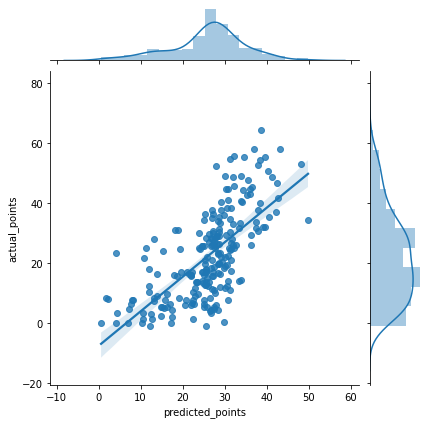

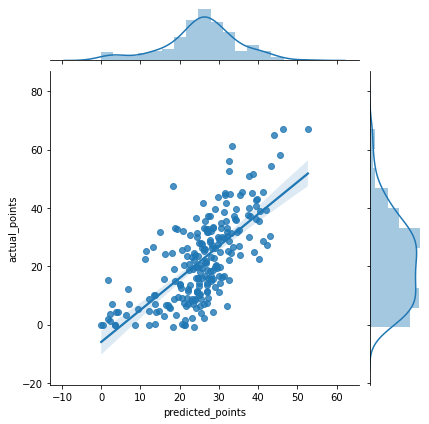

In [63]:
late_jan_box_scores["minutes"] = late_jan_box_scores["seconds_played"] / 60
# sns.distplot(jan_24_pred_actual.minutes)
# sns.distplot(july_31_predictions.minutes)
# sns.distplot(july_30_predictions.minutes)
# sns.distplot(feb_12_pred_actual.minutes)
sns.jointplot(data = feb_12_pred_actual, x = 'predicted_points', y = 'actual_points', kind = 'reg')
sns.jointplot(data = jan_24_pred_actual, x = 'predicted_points', y = 'actual_points', kind = 'reg')
# sns.distplot(feb_12_pred_actual.actual_points)
# sns.distplot(feb_12_pred_actual.predicted_points)

In [30]:
all_abbrv = {'ATL':'Atlanta', 'BOS':'Boston', 'BKN':'Brooklyn', 'CHA':'Charlotte', 'CHI':'Chicago', 'CLE':'Cleveland', 'DAL':'Dallas',
            'DEN':'Denver', 'DET':'Detroit', 'GSW':'Golden State', 'HOU':'Houston', 'IND':'Indiana', 'LAC':'LA Clippers', 'LAL':'LA Lakers',
            'MEM':'Memphis', 'MIA':'Miami', 'MIL':'Milwaukee', 'MIN':'Minnesota', 'NOR':'New Orleans', 'NYK':'New York', 'OKC':'Oklahoma City', 'ORL':'Orlando',
            'PHI':'Philadelphia', 'PHO':'Phoenix', 'POR':'Portland', 'SAC':'Sacramento', 'SAS':'San Antonio', 'TOR':'Toronto', 'UTA':'Utah', 'WAS':'Washington'}
dkp = pd.read_csv('./OutputCSVs/draftkings_points.csv')
dkp = dkp[pd.isna(dkp.position)==False]
dbp = pd.read_csv('./OutputCSVs/team_def_vs_position.csv')

ranks = []
seen = {}
player_names = [seen.setdefault(x, x) for x in dkp['name'] if x not in seen]
abbrv = [str(dkp.loc[dkp['name']==x, 'team'].iloc[0]).upper() for x in player_names]
player_positions = [dkp.loc[dkp['name']==x, 'position'].iloc[0] for x in player_names]
team_names = [all_abbrv.get(x) for x in abbrv]

for i in range(0, len(player_names)):
    if len(player_positions[i])<=2:
        ranks.append(dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i])].iloc[0])
    else:
        first_subrank =  dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i][:2])].iloc[0]
        second_subrank =  dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i][3:])].iloc[0]
        ranks.append((first_subrank + second_subrank)/2)

outputDefense = pd.DataFrame({'name':player_names, 'pos':player_positions, 'team':team_names, 'rank':ranks})
outputDefense.to_csv('./OutputCSVs/player_def_vs_position.csv', header=True, index=False)